In [1]:
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

# # Ensure deterministic behavior (cannot control everything though)
# torch.backends.cudnn.deterministic = True
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# !nvidia-smi

In [2]:
dir_ = '/workspace/raid/OM_DeepLearnin/XAMI/mobile_sam/MobileSAMv2/'

In [3]:
device_id = 3

In [4]:
import argparse
import ast
import torch
from PIL import Image
import cv2
import os
import sys

sys.path.append('/workspace/raid/OM_DeepLearnin/XAMI/mobile_sam/MobileSAMv2/')
from ultralytics import YOLO

from mobilesamv2.promt_mobilesamv2 import ObjectAwareModel
from mobilesamv2 import sam_model_registry, SamPredictor
from typing import Any, Dict, Generator,List
import matplotlib.pyplot as plt
import numpy as np

def create_model():
    Prompt_guided_path=dir_+'PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    obj_model_path=dir_+'weight/ObjectAwareModel.pt'
    ObjAwareModel = ObjectAwareModel(obj_model_path)
    PromptGuidedDecoder=sam_model_registry['PromptGuidedDecoder'](Prompt_guided_path)
    mobilesamv2 = sam_model_registry['vit_h']()
    mobilesamv2.prompt_encoder=PromptGuidedDecoder['PromtEncoder']
    mobilesamv2.mask_decoder=PromptGuidedDecoder['MaskDecoder']
    return mobilesamv2,ObjAwareModel
    
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

encoder_path={'efficientvit_l2':dir_+'weight/l2.pt',
            'tiny_vit':dir_+'weight/mobile_sam.pt',
            'sam_vit_h':dir_+'weight/sam_vit_h.pt',}

/opt/conda/envs/yolo_older_v/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/raid/OM_DeepLearnin/XAMI/mobile_sam/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearnin/XAMI/mobile_sam/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearnin/XAMI/mobile_sam/MobileSAMv2/tinyvit/tiny_vit.py:656: U

In [5]:
class Args:
    ObjectAwareModel_path = dir_+'PromptGuidedDecoder/ObjectAwareModel.pt'
    Prompt_guided_Mask_Decoder_path = dir_+'PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    encoder_path = dir_
    img_path = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
    imgsz = 512
    iou = 0.9
    conf = 0.4
    retina = False
    output_dir = '/workspace/raid/OM_DeepLearning/new_temp/'
    encoder_type = 'tiny_vit'  # choose from ['tiny_vit','sam_vit_h','mobile_sam','efficientvit_l2','efficientvit_l1','efficientvit_l0']

args = Args()

# import pdb;pdb.set_trace()
output_dir=args.output_dir  
mobilesamv2, ObjAwareModel=create_model()
image_encoder=sam_model_registry[args.encoder_type](encoder_path[args.encoder_type])
mobilesamv2.image_encoder=image_encoder
device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
mobilesamv2.to(device=device)
# mobilesamv2.eval()
predictor = SamPredictor(mobilesamv2)
image_files= os.listdir(args.img_path)

for name, param in mobilesamv2.named_parameters():
    params_to_train = ['mask_tokens', 'output_upscaling', 'output_hypernetworks_mlps', 'iou_prediction_head']
    # if 'mask_decoder' in name: # and any(s in name for s in params_to_train):
    if True:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [6]:
def check_requires_grad(model, show=True):
    for name, param in model.named_parameters():
        if param.requires_grad and show:
            print("✅ Param", name, " requires grad.")
        elif param.requires_grad == False:
            print("❌ Param", name, " doesn't require grad.")

print(f"🚀 The model has {sum(p.numel() for p in mobilesamv2.parameters() if p.requires_grad)} trainable parameters.\n")
check_requires_grad(mobilesamv2)

🚀 The model has 10130092 trainable parameters.

✅ Param image_encoder.patch_embed.seq.0.c.weight  requires grad.
✅ Param image_encoder.patch_embed.seq.0.bn.weight  requires grad.
✅ Param image_encoder.patch_embed.seq.0.bn.bias  requires grad.
✅ Param image_encoder.patch_embed.seq.2.c.weight  requires grad.
✅ Param image_encoder.patch_embed.seq.2.bn.weight  requires grad.
✅ Param image_encoder.patch_embed.seq.2.bn.bias  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv1.c.weight  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv2.c.weight  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv3.c.weight  requires grad.
✅ Param image_encoder.layers.0.blocks.0.conv3.bn.weight  requires

In [7]:
import argparse
import ast
import torch
from PIL import Image
import cv2
import os
import sys
from mobilesamv2.promt_mobilesamv2 import ObjectAwareModel
from mobilesamv2 import sam_model_registry, SamPredictor
from typing import Any, Dict, Generator,List
import matplotlib.pyplot as plt
import numpy as np
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--ObjectAwareModel_path", type=str, default='./PromptGuidedDecoder/ObjectAwareModel.pt', help="ObjectAwareModel path")
    parser.add_argument("--Prompt_guided_Mask_Decoder_path", type=str, default='./PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt', help="Prompt_guided_Mask_Decoder path")
    parser.add_argument("--encoder_path", type=str, default="./", help="select your own path")
    parser.add_argument("--img_path", type=str, default="./test_images/", help="path to image file")
    parser.add_argument("--imgsz", type=int, default=1024, help="image size")
    parser.add_argument("--iou",type=float,default=0.9,help="yolo iou")
    parser.add_argument("--conf", type=float, default=0.4, help="yolo object confidence threshold")
    parser.add_argument("--retina",type=bool,default=True,help="draw segmentation masks",)
    parser.add_argument("--output_dir", type=str, default="./", help="image save path")
    parser.add_argument("--encoder_type", choices=['tiny_vit','sam_vit_h','mobile_sam','efficientvit_l2','efficientvit_l1','efficientvit_l0'], help="choose the model type")
    return parser.parse_args()

def create_model():
    Prompt_guided_path=dir_+'PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    obj_model_path=dir_+'weight/ObjectAwareModel.pt'
    ObjAwareModel = ObjectAwareModel(obj_model_path)
    PromptGuidedDecoder=sam_model_registry['PromptGuidedDecoder'](Prompt_guided_path)
    mobilesamv2 = sam_model_registry['vit_h']()
    mobilesamv2.prompt_encoder=PromptGuidedDecoder['PromtEncoder']
    mobilesamv2.mask_decoder=PromptGuidedDecoder['MaskDecoder']
    return mobilesamv2,ObjAwareModel
    
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    # ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]


encoder_path={'efficientvit_l2':dir_+'weight/l2.pt',
            'tiny_vit':dir_+'weight/mobile_sam.pt',
            'sam_vit_h':dir_+'weight/sam_vit_h.pt',}

***** S0674810801_M.png



0: 512x512 1 object, 8.9ms
Speed: 5.5ms preprocess, 8.9ms inference, 6.8ms postprocess per image at shape (1, 3, 512, 512)


ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 

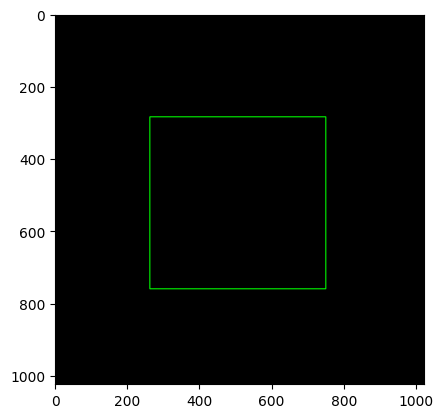

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.81 GiB. GPU 3 has a total capacity of 39.39 GiB of which 2.44 GiB is free. Process 915220 has 36.95 GiB memory in use. Of the allocated memory 35.18 GiB is allocated by PyTorch, and 111.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
def main(args):
    # import pdb;pdb.set_trace()
    output_dir=args.output_dir  
    mobilesamv2, ObjAwareModel=create_model()
    image_encoder=sam_model_registry[args.encoder_type](encoder_path[args.encoder_type])
    mobilesamv2.image_encoder=image_encoder
    device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
    mobilesamv2.to(device=device)
    mobilesamv2.train()
    predictor = SamPredictor(mobilesamv2)
    image_files= os.listdir(args.img_path)
    for image_name in image_files[:10]:
        print('*****', image_name)
        image = cv2.imread(args.img_path + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        obj_results = ObjAwareModel(image,device=device,retina_masks=args.retina,imgsz=args.imgsz,conf=args.conf,iou=args.iou)
        if obj_results is None:
            print("No mask here")
            continue
        print(obj_results[0])
        predictor.set_image(image)
        input_boxes1 = obj_results[0].boxes.xyxy
        input_boxes = input_boxes1.cpu().numpy()
        input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
        input_boxes = torch.from_numpy(input_boxes).to(device)
        sam_mask=[]
        image_embedding=predictor.features
        image_embedding=torch.repeat_interleave(image_embedding, 720, dim=0)
        prompt_embedding=mobilesamv2.prompt_encoder.get_dense_pe()
        prompt_embedding=torch.repeat_interleave(prompt_embedding, 720, dim=0)
        
        # for (boxes,) in batch_iterator(320, input_boxes):
            # with torch.no_grad():
        image1 = np.zeros((1024, 1024, 3), dtype=np.uint8)
        
        for bbox in input_boxes:
            x1, y1, x2, y2 = bbox.detach().cpu().numpy()
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle with thickness 2
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        plt.imshow(image1)
        plt.show()
        plt.close()

        # image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
        # prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
        sparse_embeddings, dense_embeddings = mobilesamv2.prompt_encoder(
            points=None,
            boxes=input_boxes,
            masks=None,)
        low_res_masks, _ = mobilesamv2.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=prompt_embedding,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            simple_type=True,
        )
        low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
        sam_mask_pre = (low_res_masks > mobilesamv2.mask_threshold)*1.0
        sam_mask.append(sam_mask_pre.squeeze(1))
        # print(sam_mask[0].shape)
        sam_mask=torch.cat(sam_mask)
        # print(sam_mask.shape)
        annotation = sam_mask
        areas = torch.sum(annotation, dim=(1, 2))
        sorted_indices = torch.argsort(areas, descending=True)
        show_img = annotation[sorted_indices]
        plt.figure(figsize=(5,5))
        background=np.ones_like(image)*255
        plt.imshow(background)
        # print('torch', show_img.shape)
        show_anns(show_img)
        plt.axis('off')
        plt.show() 
        # plt.savefig("{}".format(output_dir+image_name), bbox_inches='tight', pad_inches = 0.0) 
        plt.close()

args = Args()
main(args)